#### Import libraries and framework

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
NUMBER_OF_VARS_TO_USE = 5 # 5 OR 15 OR 25

#### Prepare the data

In [3]:
# Load the data from the CSV file into a DataFrame
data = pd.read_csv('datasets/listings_preprocessed.csv')
selected_vars = pd.read_csv('datasets/high_correlations_price.csv').values.tolist()
selected_vars = selected_vars[0:NUMBER_OF_VARS_TO_USE]
    
for i, var in enumerate(selected_vars):
    selected_vars[i] = var[0]
    
# Separate the input features (X) and target variable (y)
X = data.loc[:, selected_vars]
y = data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Align the columns of the training and testing sets
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Fill missing values in the training set with the mean of each column
X_train.fillna(X_train.mean(), inplace=True)

# Fill missing values in the test set with the mean of the corresponding columns in the training set
X_test.fillna(X_train.mean(), inplace=True)

# Fill remaining NaN values with 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [4]:
def linear_regression_performance(X_train, y_train, X_test, y_test):
    # Create a linear regression model
    model = LinearRegression()

    # Train the model using the training data with the selected features
    model.fit(X_train, y_train)

    # Predict the prices for the test set
    y_pred = model.predict(X_test)

    # Calculate the mean squared error and R^2 score for the predictions
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the coefficients of the linear regression model
    coefficients = model.coef_
    print("Linear regression model coefficients")
    for feature, coef in zip(selected_vars, coefficients):
        print(f"{feature}: {coef}")

    # Print the results
    print("\nPerformance metrics")
    print("Mean squared error:", mse)
    print("R^2 score:", r2)

    return mse, r2, y_pred

mse, r2, y_pred = linear_regression_performance(X_train, y_train, X_test, y_test)

Linear regression model coefficients
bedrooms: 73.4027323428829
room_type_Private room: -19.484279206013714
calculated_host_listings_count_entire_homes: 0.47050236733725465
property_type_Private room in rental unit: -35.84374550403137
minimum_nights: -0.9864976125499327

Performance metrics
Mean squared error: 8543.04326816733
R^2 score: 0.48178142872762253


#### Visualize the performance of the regression model

##### Create a scatter plot of the true prices (y_test) against the predicted prices (y_pred)

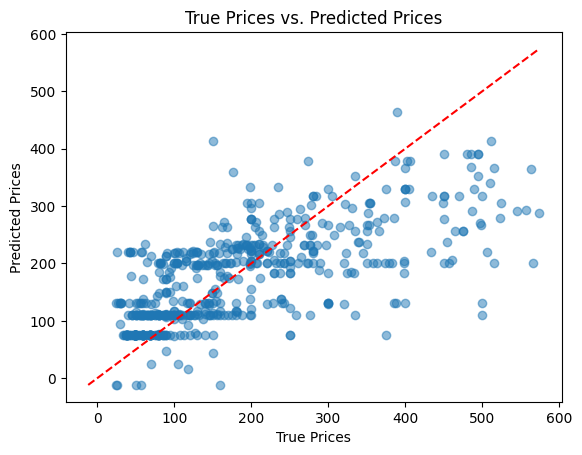

In [5]:
def plot_true_vs_predicted(y_test, y_pred):
    # Create a scatter plot of the true prices against the predicted prices
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('True Prices')
    plt.ylabel('Predicted Prices')
    plt.title('True Prices vs. Predicted Prices')

    # Convert y_test and y_pred to NumPy arrays
    y_test_np = np.array(y_test)
    y_pred_np = np.array(y_pred)

    # Add a diagonal line to represent perfect predictions
    min_val = min(y_test_np.min(), y_pred_np.min())
    max_val = max(y_test_np.max(), y_pred_np.max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

    # Show the plot
    plt.show()

plot_true_vs_predicted(y_test, y_pred)

#### Visualize the performance of the regression model for individual features

In [6]:
def individual_feature_performance(X_train, y_train, X_test, y_test):
    # Initialize lists to store R^2 scores and coefficients
    r2_scores = []
    coefficients = []

    # Loop through the top k features with the highest absolute correlation values
    for feature in selected_vars:
        # Create a linear regression model
        model = LinearRegression()

        # Train the model using the individual feature from the training data
        model.fit(X_train[[feature]], y_train)

        # Predict the prices for the test set
        y_pred = model.predict(X_test[[feature]])

        # Calculate the R^2 score for the predictions
        r2 = r2_score(y_test, y_pred)

        # Append the R^2 score and coefficient to the respective lists
        r2_scores.append(r2)
        coefficients.append(model.coef_[0])

    # Print the R^2 scores and coefficients for each feature
    for feature, r2, coef in zip(selected_vars, r2_scores, coefficients):
        print(f"{feature}: R^2 = {r2:.4f}, Coefficient = {coef:.4f}")

    return r2_scores, coefficients

r2_scores, coefficients = individual_feature_performance(X_train, y_train, X_test, y_test)

bedrooms: R^2 = 0.2281, Coefficient = 90.1501
room_type_Private room: R^2 = 0.2129, Coefficient = -106.5430
calculated_host_listings_count_entire_homes: R^2 = 0.1909, Coefficient = 0.7649
property_type_Private room in rental unit: R^2 = 0.1546, Coefficient = -118.4313
minimum_nights: R^2 = 0.1155, Coefficient = -1.0541


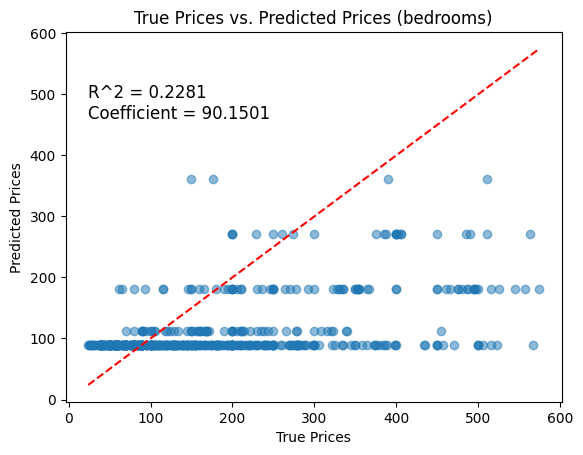

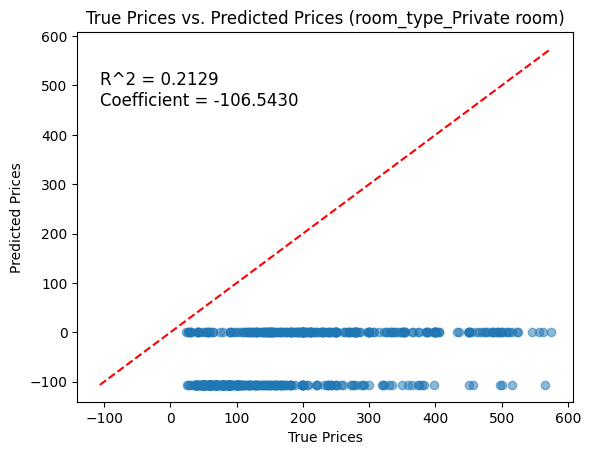

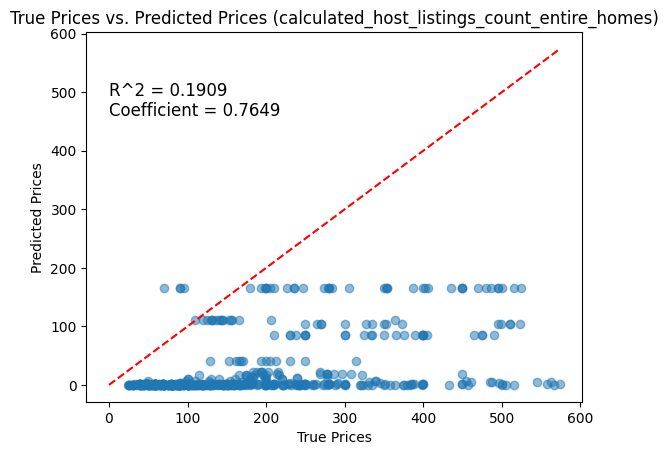

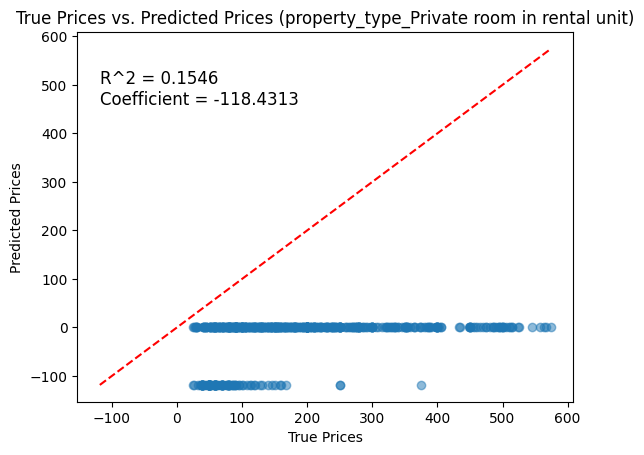

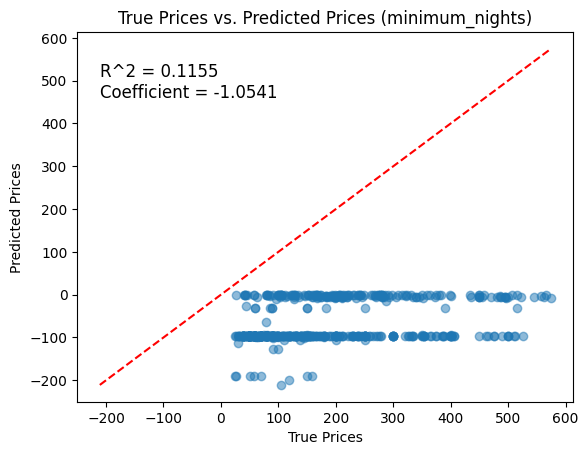

In [7]:
def plot_regression(feature, y_test, y_pred, r2, coef):
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('True Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'True Prices vs. Predicted Prices ({feature})')

    min_val = min(y_test.min(), y_pred.min()[0])
    max_val = max(y_test.max(), y_pred.max()[0])
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

    plt.text(min_val, max_val * 0.8, f'R^2 = {r2:.4f}\nCoefficient = {coef:.4f}', fontsize=12)
    plt.show()

for feature, r2, coef in zip(selected_vars, r2_scores, coefficients):
    y_pred = X_test[[feature]] * coef
    plot_regression(feature, y_test, y_pred, r2, coef)